# Семинар 2 - метрики качества, валидация,  kNN

In [46]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 4)})
import scipy.stats as st

import warnings
warnings.simplefilter('ignore')

Источник данных: [Соревнование в рамках курса  ODS](https://www.kaggle.com/c/flight-delays-2017)

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [48]:
# Загрузим данные 
data = pd.read_csv('../data/flight_delays_train.csv')
data.shape

(100000, 9)

In [49]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [50]:
n = data[data['dep_delayed_15min']== 'N'].shape[0]
y = data[data['dep_delayed_15min']== 'Y'].shape[0] 

print(np.round(n/(n+y)*100, decimals=2), '% рейсов задержек нет')
print(np.round(y/(n+y)*100, decimals=2), '% рейсов Задержка рейса более 15 минут')


80.96 % рейсов задержек нет
19.04 % рейсов Задержка рейса более 15 минут


In [51]:
#Переведем целевую переменную к численному значению
data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)

In [52]:
#Уберем из дат 'c-'
data['Month'] = data['Month'].str.replace('c-', '').astype('int16')
data['DayofMonth'] = data['DayofMonth'].str.replace('c-', '').astype('int16')
data['DayOfWeek'] = data['DayOfWeek'].str.replace('c-', '').astype('int16')

In [53]:
#Посмотрим кол-во уникальных значения для категориальных признаков
data[['UniqueCarrier','Origin','Dest']].nunique()

UniqueCarrier     22
Origin           289
Dest             289
dtype: int64

In [54]:
# Факторизуем категориальные переменные
data['UniqueCarrier'] = pd.factorize(data['UniqueCarrier'])[0]
data['Origin'] = pd.factorize(data['Origin'])[0]
data['Dest'] = pd.factorize(data['Dest'])[0]

data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,0,0,0,732,0
1,4,20,3,1548,1,1,1,834,0
2,9,2,5,1422,2,2,2,416,0
3,11,25,6,1015,3,3,3,872,0
4,10,7,6,1828,4,4,4,423,1


In [55]:
# Сформируем матрицу признаков и вектор целевой переменной
x = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].values

In [56]:
#Разделим выборку на обущающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, \
                                                    shuffle=True, random_state=18)

In [57]:
# Сделаем предсказание с помощью kNN
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)
print('на тесте: F1 - ', f1_score(y_test, prediction), 
      'accuracy - ', accuracy_score(y_test, prediction))
print('на трейне: F1 - ', f1_score(y_train, knn.predict(x_train)), 
       'accuracy - ', accuracy_score(y_train, knn.predict(x_train)))

на тесте: F1 -  0.26464128843338214 accuracy -  0.7991
на трейне: F1 -  0.46465364120781527 accuracy -  0.8493


In [58]:
#Оценим качество с помощью крос-валидации на 5 фолдах

def cros_val(scoring, est, x, y, fold):
    result = cross_val_score(est, x, y, scoring=scoring, cv=fold)
    return np.round(np.mean(result), decimals=2)

print('accuracy: ', cros_val('accuracy', knn, x_train, y_train, 5))
print('precision: ', cros_val('precision', knn, x_train, y_train, 5))
print('recall: ', cros_val('recall', knn, x_train, y_train, 5))
print('F1: ', cros_val('f1', knn, x_train, y_train, 5))

accuracy:  0.8
precision:  0.43
recall:  0.19
F1:  0.26


In [59]:
# Построим  кривые обучения и валидации
train_score = []
test_score = []
for i in range(30):
    knn = KNeighborsClassifier(n_neighbors=i+1, n_jobs=-1)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    train_score = np.append(train_score, accuracy_score(y_train, knn.predict(x_train)))
    test_score = np.append(test_score, accuracy_score(y_test, prediction))

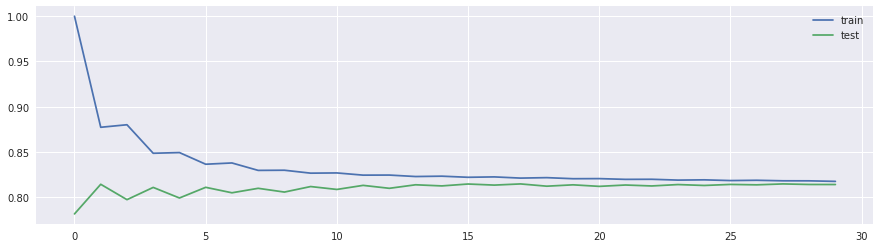

In [60]:
plt.plot(train_score, label="train")
plt.plot(test_score, label="test")
plt.legend()
plt.show()

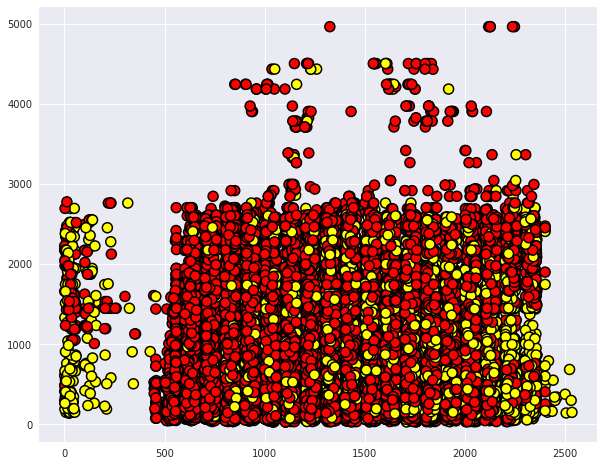

In [61]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(x_train['DepTime'], x_train['Distance'], c=y_train, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

Так как, наши категориальные признаки не имеют ранжирования. Применим One-Hot-Encoding

In [62]:
x = pd.get_dummies(x, columns=['UniqueCarrier', 'Origin','Dest'])

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, \
                                                    shuffle=True, random_state=18)

In [64]:
# Сделаем предсказание с помощью kNN
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)
print('на тесте: F1 - ', f1_score(y_test, prediction), 
      'accuracy - ', accuracy_score(y_test, prediction))
print('на трейне: F1 - ', f1_score(y_train, knn.predict(x_train)), 
       'accuracy - ', accuracy_score(y_train, knn.predict(x_train)))

на тесте: F1 -  0.22652647113078767 accuracy -  0.79035
на трейне: F1 -  0.43136547994592167 accuracy -  0.842275


In [65]:
# Попробуем применить шкалирвоание данных:
from sklearn.preprocessing import MinMaxScaler

In [66]:
x = data.drop(['dep_delayed_15min', 'UniqueCarrier', 'Origin', 'Dest'], axis=1) # Возьмем не все признаки
y = data['dep_delayed_15min'].values

In [67]:
mms = MinMaxScaler()
x = mms.fit_transform(x)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, \
                                                    shuffle=True, random_state=18)

In [69]:
print('accuracy: ', cros_val('accuracy', knn, x_train, y_train, 5))
print('precision: ', cros_val('precision', knn, x_train, y_train, 5))
print('recall: ', cros_val('recall', knn, x_train, y_train, 5))
print('F1: ', cros_val('f1', knn, x_train, y_train, 5))

accuracy:  0.79
precision:  0.38
recall:  0.17
F1:  0.24
